## Decision trees with some form of pruning

## Neural networks

## Boosting

## Support Vector Machines

## k-nearest neighbors

In [3]:
import numpy as np
import pandas as pd
import timeit
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, learning_curve, ShuffleSplit
from sklearn.metrics import auc, roc_curve, confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import preprocessing
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

cc = pd.read_csv("data/creditcard.csv")
zoo = pd.read_csv("data/zoo.csv")

### EXPLORATORY DATA ANALYSIS

In [4]:
cc.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


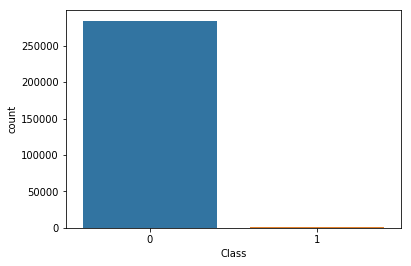

In [5]:
sns.countplot(cc['Class'],label="Count")

In [6]:
zoo.head()

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


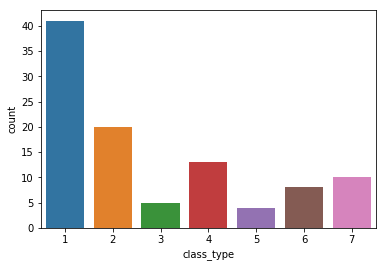

In [7]:
sns.countplot(zoo['class_type'],label="Count")

### Train & Test

In [8]:
from sklearn.model_selection import train_test_split

y_cc = cc.iloc[:,-1:]
x_cc = cc.iloc[:,:-1]

print("Credit Card Data:")
print("Feature Data :", x_cc.shape)
print("Label Data :", y_cc.shape)

x_cc_train, x_cc_test, y_cc_train, y_cc_test = train_test_split(x_cc, y_cc, random_state=100, stratify=y_cc)

from sklearn import preprocessing

y_zoo = zoo.iloc[:,-1:]
x_zoo = zoo.iloc[:,1:-1]

print("\nZoo Data:")
print("Feature Data :", x_zoo.shape)
print("Label Data :", y_zoo.shape)

x_zoo_train, x_zoo_test, y_zoo_train, y_zoo_test = train_test_split(x_zoo, y_zoo, test_size=0.3, random_state=100, stratify=y_zoo)

Credit Card Data:
Feature Data : (284807, 30)
Label Data : (284807, 1)

Zoo Data:
Feature Data : (101, 16)
Label Data : (101, 1)


In [9]:
# Code taken from Sklearn
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

## Decision Tree with Pruning

In [10]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import auc, roc_curve, confusion_matrix
from sklearn import metrics

# def prune(decisiontree, min_samples_leaf = 1):
#     if decisiontree.min_samples_leaf >= min_samples_leaf:
#         raise Exception('Tree already more pruned')
#     else:
#         decisiontree.min_samples_leaf = min_samples_leaf
#         tree = decisiontree.tree_
#         for i in range(tree.node_count):
#             n_samples = tree.n_node_samples[i]
#             if n_samples <= min_samples_leaf:
#                 tree.children_left[i]=-1
#                 tree.children_right[i]=-1

In [11]:
# CC Not taking into account unbalanced dataset

parameters = {'min_samples_leaf':[5, 7, 15, 50, 75], 'max_features': ['sqrt', 'log2']}
dtc = DecisionTreeClassifier()
clf = RandomizedSearchCV(dtc, parameters, verbose=2, cv=10, n_jobs=-1)
clf.fit(x_cc_train, y_cc_train)
y_cc_preds = clf.predict(x_cc_test)

roc_auc = metrics.roc_auc_score(y_cc_test, y_cc_preds)
precision = metrics.precision_score(y_cc_test, y_cc_preds)
recall = metrics.recall_score(y_cc_test, y_cc_preds)
accuracy = metrics.accuracy_score(y_cc_test, y_cc_preds)

print("Best params for cc: \n{}\n".format(clf.best_params_))
print("ROC AUC: {}\nRecall: {}\nPrecision: {}\nAccuracy: {}".format(roc_auc, recall, precision, accuracy))

# zoo Not taking into account unbalanced dataset             
parameters = {'min_samples_leaf':[5, 7, 15, 50, 75], 'max_features': ['sqrt', 'log2']}
clf = RandomizedSearchCV(dtc, parameters, verbose=2, cv=10, n_jobs=-1)
clf.fit(x_zoo_train, y_zoo_train)
y_zoo_preds = clf.predict(x_zoo_test)

accuracy_score = metrics.accuracy_score(y_zoo_test, y_zoo_preds)

print("Best params for zoo: \n{}".format(clf.best_params_))
print("Accuracy: {}".format(accuracy_score))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.0min finished


Best params for cc: 
{'min_samples_leaf': 5, 'max_features': 'sqrt'}

ROC AUC: 0.8454299733137879
Recall: 0.6910569105691057
Precision: 0.8585858585858586
Accuracy: 0.9992696834358585
Fitting 10 folds for each of 10 candidates, totalling 100 fits


C:\Users\kinguyen\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best params for zoo: 
{'min_samples_leaf': 5, 'max_features': 'log2'}
Accuracy: 0.8387096774193549


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
C:\Users\kinguyen\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished


Best params for cc: 
{'min_samples_leaf': 5, 'max_features': 'sqrt', 'class_weight': 'balanced'}

ROC AUC: 0.8734420889981913
Recall: 0.7479674796747967
Precision: 0.5443786982248521
Accuracy: 0.9984831886744754


C:\Users\kinguyen\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


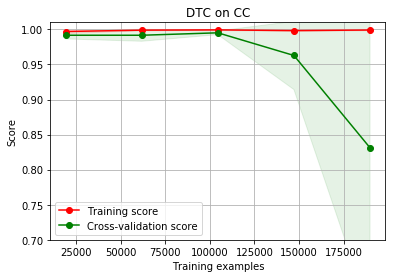

In [15]:
# CC
parameters = {'min_samples_leaf':[5, 7, 15, 50, 75], 'max_features': ['sqrt', 'log2'], 'class_weight': ['balanced']}
dtc = DecisionTreeClassifier()
clf = RandomizedSearchCV(dtc, parameters, verbose=2, cv=10, n_jobs=-1, random_state=100)
clf.fit(x_cc_train, y_cc_train)
y_cc_preds = clf.predict(x_cc_test)

roc_auc = metrics.roc_auc_score(y_cc_test, y_cc_preds)
precision = metrics.precision_score(y_cc_test, y_cc_preds)
recall = metrics.recall_score(y_cc_test, y_cc_preds)
accuracy = metrics.accuracy_score(y_cc_test, y_cc_preds)

print("Best params for cc: \n{}\n".format(clf.best_params_))
print("ROC AUC: {}\nRecall: {}\nPrecision: {}\nAccuracy: {}".format(roc_auc, recall, precision, accuracy))

title = "DTC on CC"
plot_learning_curve(clf, title, x_cc, y_cc, ylim=(0.7, 1.01), n_jobs=-1)
plt.show()


In [20]:
# zoo             
parameters = {'min_samples_leaf':[5, 7, 15, 50, 75], 'max_features': ['sqrt', 'log2'], 'class_weight': ['balanced']}
clf = RandomizedSearchCV(dtc, parameters, verbose=2, cv=10, n_jobs=-1, random_state=100)
clf.fit(x_zoo_train, y_zoo_train)
y_zoo_preds = clf.predict(x_zoo_test)

accuracy_score = metrics.accuracy_score(y_zoo_test, y_zoo_preds)

print("Best params for zoo: \n{}".format(clf.best_params_))
print("Accuracy: {}".format(accuracy_score))
# cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
# title = "DTC on Zoo"
# plot_learning_curve(clf, title, x_zoo, y_zoo, cv=cv, ylim=(0.7, 1.01), n_jobs=-1)
# plt.show()

Fitting 10 folds for each of 10 candidates, totalling 100 fits


C:\Users\kinguyen\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  42 out of 100 | elapsed:    7.0s remaining:    9.8s


Best params for zoo: 
{'min_samples_leaf': 5, 'max_features': 'sqrt', 'class_weight': 'balanced'}
Accuracy: 0.8064516129032258


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.5s finished
C:\Users\kinguyen\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [11]:
from sklearn.utils.multiclass import unique_labels

zoo_classes = unique_labels(y_zoo_test, y_zoo_preds)

In [22]:
# Code adapted from Sklearn

import itertools
np.set_printoptions(precision=2)

import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[1.   0.  ]
 [0.24 0.76]]


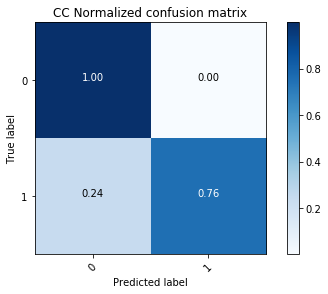

In [12]:
# Plot normalized confusion matrix for cc
cnf_matrix_cc = confusion_matrix(y_cc_test, y_cc_preds)
plt.figure()
plot_confusion_matrix(cnf_matrix_cc, classes=[0,1], normalize=True,
                      title='CC Normalized confusion matrix')

plt.show()

Normalized confusion matrix
[[1.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.5  0.5  0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   0.   0.67 0.33]]


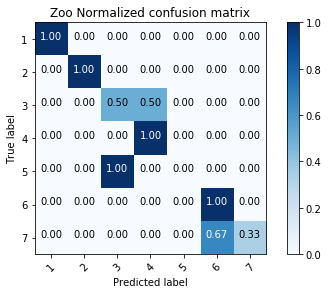

In [13]:
# Plot normalized confusion matrix for zoo
cnf_matrix_zoo = confusion_matrix(y_zoo_test, y_zoo_preds)
plt.figure()
plot_confusion_matrix(cnf_matrix_zoo, classes=zoo_classes, normalize=True,
                      title='Zoo Normalized confusion matrix')

plt.show()

In [14]:
# for CC
print(cnf_matrix_cc)
tn, fp = cnf_matrix_cc[0]
fn, tp = cnf_matrix_cc[1]
recall = tp/ float((tp + fn))
precision = tp / float((tp + fp))
accuracy = (tp + tn) / float(tp+tn+fp+fn)

[[70996    83]
 [   30    93]]


In [15]:
print("Recall: {}\nPrecision: {}\nAccuracy: {}".format(recall, precision, accuracy))

Recall: 0.7560975609756098
Precision: 0.5284090909090909
Accuracy: 0.9984129659279234


## KNN

C:\Users\kinguyen\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """Entry point for launching an IPython kernel.
C:\Users\kinguyen\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """Entry point for launching an IPython kernel.
C:\Users\kinguyen\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """Entry point for launching an IPython kernel.
C:\Users\kinguyen\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykern

1.78 s ± 182 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.02 s ± 24.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
ROC AUC: 0.8734420889981913
Recall: 0.7479674796747967
Precision: 0.5443786982248521
Accuracy: 0.9984831886744754


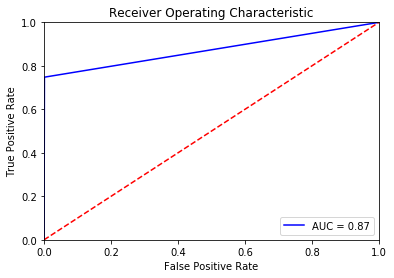

Normalized confusion matrix
[[1.   0.  ]
 [0.25 0.75]]


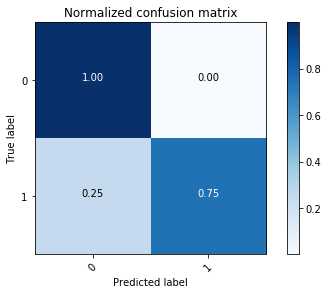

In [23]:
from sklearn.neighbors import KNeighborsClassifier

# CC
knn_cc = KNeighborsClassifier()
%timeit knn_cc.fit(x_cc_train, y_cc_train)
%timeit y_cc_preds = knn_cc.predict(x_cc_test)

roc_auc = metrics.roc_auc_score(y_cc_test, y_cc_preds)
precision = metrics.precision_score(y_cc_test, y_cc_preds)
recall = metrics.recall_score(y_cc_test, y_cc_preds)
accuracy = metrics.accuracy_score(y_cc_test, y_cc_preds)

print("ROC AUC: {}\nRecall: {}\nPrecision: {}\nAccuracy: {}".format(roc_auc, recall, precision, accuracy))
fpr, tpr, threshold = roc_curve(y_cc_test, y_cc_preds)
roc_auc = auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

cnf_matrix_cc = confusion_matrix(y_cc_test, y_cc_preds)
plt.figure()
plot_confusion_matrix(cnf_matrix_cc, classes=[0, 1], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

C:\Users\kinguyen\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


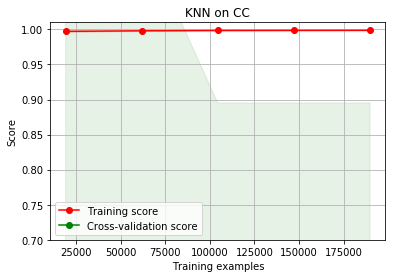

In [24]:
title = "KNN on CC"
plot_learning_curve(knn_cc, title, x_cc, y_cc, ylim=(0.7, 1.01), n_jobs=-1)
plt.show()

In [ ]:
# zoo
knn_zoo = KNeighborsClassifier()
knn_zoo.fit(x_zoo_train, y_zoo_train)
y_zoo_preds = knn_zoo.predict(x_zoo_test)

cnf_matrix_zoo = confusion_matrix(y_zoo_test, y_zoo_preds)
plt.figure()
plot_confusion_matrix(cnf_matrix_zoo, classes=zoo_classes, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

accuracy = metrics.accuracy_score(y_zoo_test, y_zoo_preds)

print("Accuracy: {}".format(accuracy))

## Neural Networks

C:\Users\kinguyen\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kinguyen\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


ROC AUC: 0.5
Recall: 0.0
Precision: 0.0
Accuracy: 0.9982725204348193


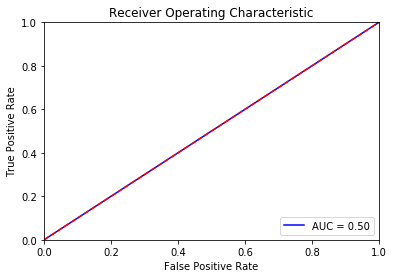

Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


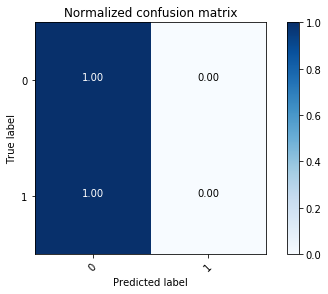

In [25]:
from sklearn.neural_network import MLPClassifier

# CC
nn_cc = MLPClassifier(random_state=100)
nn_cc.fit(x_cc_train, y_cc_train)
y_cc_preds = nn_cc.predict(x_cc_test)

roc_auc = metrics.roc_auc_score(y_cc_test, y_cc_preds)
precision = metrics.precision_score(y_cc_test, y_cc_preds)
recall = metrics.recall_score(y_cc_test, y_cc_preds)
accuracy = metrics.accuracy_score(y_cc_test, y_cc_preds)

print("ROC AUC: {}\nRecall: {}\nPrecision: {}\nAccuracy: {}".format(roc_auc, recall, precision, accuracy))
fpr, tpr, threshold = roc_curve(y_cc_test, y_cc_preds)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

cnf_matrix_cc = confusion_matrix(y_cc_test, y_cc_preds)
plt.figure()
plot_confusion_matrix(cnf_matrix_cc, classes=[0, 1], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

C:\Users\kinguyen\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


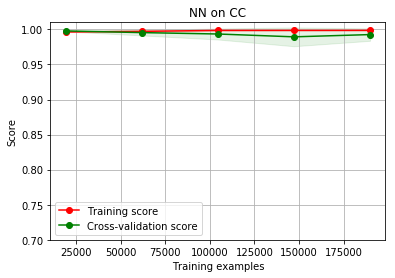

In [26]:
title = "NN on CC"
plot_learning_curve(nn_cc, title, x_cc, y_cc, ylim=(0.7, 1.01), n_jobs=-1)
plt.show()

C:\Users\kinguyen\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kinguyen\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Normalized confusion matrix
[[1.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.5  0.5  0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   0.   0.33 0.67]]


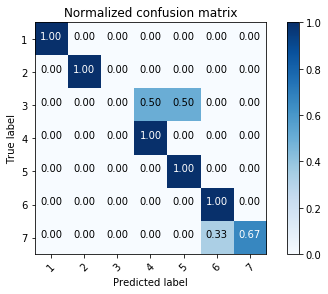

Accuracy: 0.9032258064516129


In [19]:
# zoo
nn_zoo = MLPClassifier(random_state=100)
nn_zoo.fit(x_zoo_train, y_zoo_train)
y_zoo_preds = nn_zoo.predict(x_zoo_test)

cnf_matrix_zoo = confusion_matrix(y_zoo_test, y_zoo_preds)
plt.figure()
plot_confusion_matrix(cnf_matrix_zoo, classes=zoo_classes, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

accuracy = metrics.accuracy_score(y_zoo_test, y_zoo_preds)

print("Accuracy: {}".format(accuracy))

In [ ]:
# title = "NN on Zoo"
# plot_learning_curve(nn_zoo, title, x_cc, y_cc, ylim=(0.7, 1.01), n_jobs=-1)
# plt.show()

## SVM

In [ ]:
from sklearn.svm import SVC

# CC
svm_cc = SVC(kernel='rbf', random_state=100)
svm_cc.fit(x_cc_train, y_cc_train)
y_cc_preds = svm_cc.predict(x_cc_test)

roc_auc = metrics.roc_auc_score(y_cc_test, y_cc_preds)
precision = metrics.precision_score(y_cc_test, y_cc_preds)
recall = metrics.recall_score(y_cc_test, y_cc_preds)
accuracy = metrics.accuracy_score(y_cc_test, y_cc_preds)

print("ROC AUC: {}\nRecall: {}\nPrecision: {}\nAccuracy: {}".format(roc_auc, recall, precision, accuracy))
fpr, tpr, threshold = roc_curve(y_cc_test, y_cc_preds)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

cnf_matrix_cc = confusion_matrix(y_cc_test, y_cc_preds)
plt.figure()
plot_confusion_matrix(cnf_matrix_cc, classes=[0, 1], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

C:\Users\kinguyen\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kinguyen\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


C:\Users\kinguyen\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kinguyen\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


ROC AUC: 0.524390243902439
Recall: 0.04878048780487805
Precision: 1.0
Accuracy: 0.9983567877306817


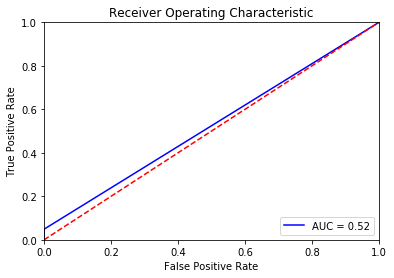

Normalized confusion matrix
[[1.   0.  ]
 [0.95 0.05]]


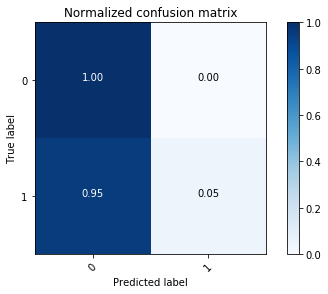

C:\Users\kinguyen\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
svm_cc = SVC(kernel='linear', random_state=100)
svm_cc.fit(x_cc_train, y_cc_train)
y_cc_preds = svm_cc.predict(x_cc_test)

roc_auc = metrics.roc_auc_score(y_cc_test, y_cc_preds)
precision = metrics.precision_score(y_cc_test, y_cc_preds)
recall = metrics.recall_score(y_cc_test, y_cc_preds)
accuracy = metrics.accuracy_score(y_cc_test, y_cc_preds)

print("ROC AUC: {}\nRecall: {}\nPrecision: {}\nAccuracy: {}".format(roc_auc, recall, precision, accuracy))
fpr, tpr, threshold = roc_curve(y_cc_test, y_cc_preds)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

cnf_matrix_cc = confusion_matrix(y_cc_test, y_cc_preds)
plt.figure()
plot_confusion_matrix(cnf_matrix_cc, classes=[0, 1], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
# zoo
svm_zoo = SVC(kernel='rbf', random_state=100)
svm_zoo.fit(x_zoo_train, y_zoo_train)
y_zoo_preds = svm_zoo.predict(x_zoo_test)

cnf_matrix_zoo = confusion_matrix(y_zoo_test, y_zoo_preds)
plt.figure()
plot_confusion_matrix(cnf_matrix_zoo, classes=zoo_classes, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

accuracy = metrics.accuracy_score(y_zoo_test, y_zoo_preds)

print("Accuracy: {}".format(accuracy))

C:\Users\kinguyen\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kinguyen\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Normalized confusion matrix
[[1.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.  ]
 [0.5  0.   0.   0.5  0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   0.   0.33 0.67]]


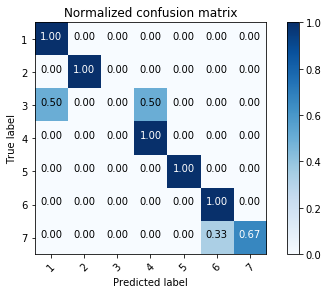

Accuracy: 0.9032258064516129
Normalized confusion matrix
[[1.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.5  0.5  0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   0.   0.33 0.67]]


C:\Users\kinguyen\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


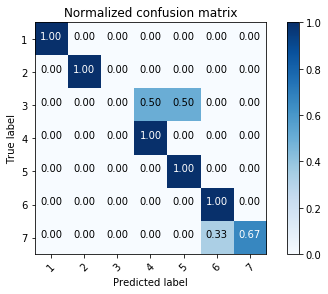

Accuracy: 0.9032258064516129


In [13]:

svm_zoo = SVC(kernel='linear', random_state=100)
svm_zoo.fit(x_zoo_train, y_zoo_train)
y_zoo_preds = svm_zoo.predict(x_zoo_test)

cnf_matrix_zoo = confusion_matrix(y_zoo_test, y_zoo_preds)
plt.figure()
plot_confusion_matrix(cnf_matrix_zoo, classes=zoo_classes, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

accuracy = metrics.accuracy_score(y_zoo_test, y_zoo_preds)

print("Accuracy: {}".format(accuracy))

## GradientBoosting

C:\Users\kinguyen\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ROC AUC: 0.6706472941992747
Recall: 0.34146341463414637
Precision: 0.7777777777777778
Accuracy: 0.9986938569141316


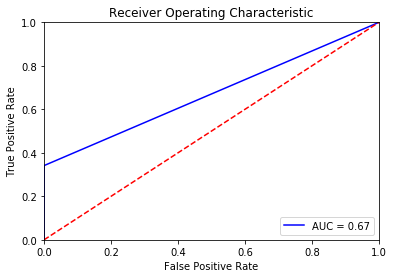

Normalized confusion matrix
[[1.00e+00 1.69e-04]
 [6.59e-01 3.41e-01]]


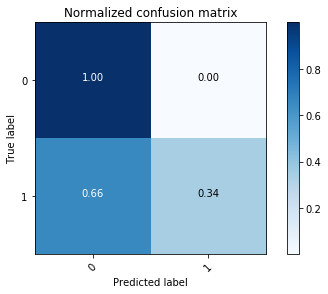

In [27]:
from sklearn.ensemble import GradientBoostingClassifier
# CC
boosting_cc = GradientBoostingClassifier(min_samples_split=20, random_state=100)
boosting_cc.fit(x_cc_train, y_cc_train)
y_cc_preds = boosting_cc.predict(x_cc_test)

roc_auc = metrics.roc_auc_score(y_cc_test, y_cc_preds)
precision = metrics.precision_score(y_cc_test, y_cc_preds)
recall = metrics.recall_score(y_cc_test, y_cc_preds)
accuracy = metrics.accuracy_score(y_cc_test, y_cc_preds)

print("ROC AUC: {}\nRecall: {}\nPrecision: {}\nAccuracy: {}".format(roc_auc, recall, precision, accuracy))
fpr, tpr, threshold = roc_curve(y_cc_test, y_cc_preds)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

cnf_matrix_cc = confusion_matrix(y_cc_test, y_cc_preds)
plt.figure()
plot_confusion_matrix(cnf_matrix_cc, classes=[0, 1], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

C:\Users\kinguyen\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


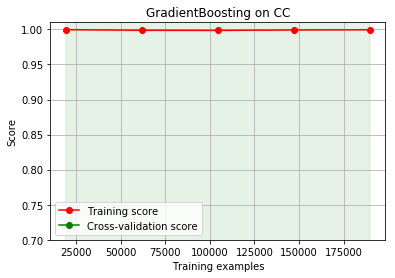

In [28]:
title = "GradientBoosting on CC"
plot_learning_curve(boosting_cc, title, x_cc, y_cc, ylim=(0.7, 1.01), n_jobs=-1)
plt.show()

C:\Users\kinguyen\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[1.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.5  0.5  0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   0.   0.33 0.67]]


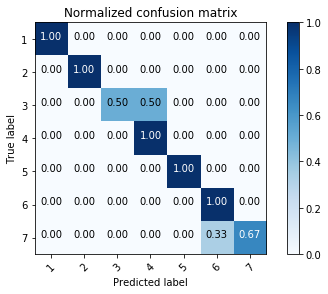

Accuracy: 0.9354838709677419


In [17]:
# zoo
boosting_zoo = GradientBoostingClassifier(min_samples_split=20, random_state=100)
boosting_zoo.fit(x_zoo_train, y_zoo_train)
y_zoo_preds = boosting_zoo.predict(x_zoo_test)

cnf_matrix_zoo = confusion_matrix(y_zoo_test, y_zoo_preds)
plt.figure()
plot_confusion_matrix(cnf_matrix_zoo, classes=zoo_classes, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

accuracy = metrics.accuracy_score(y_zoo_test, y_zoo_preds)

print("Accuracy: {}".format(accuracy))

In [ ]:
title = "Gradient Boosting on Zoo"
plot_learning_curve(boosting_zoo, title, x_cc, y_cc, ylim=(0.7, 1.01), n_jobs=-1)
plt.show()

## AdaBoostClassifier

C:\Users\kinguyen\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ROC AUC: 0.8412945883985494
Recall: 0.6829268292682927
Precision: 0.7777777777777778
Accuracy: 0.999115193393444


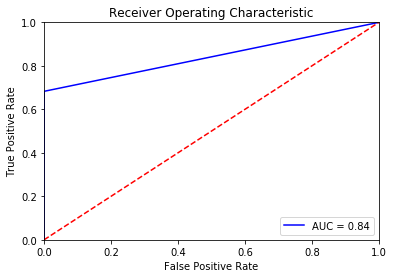

Normalized confusion matrix
[[1.00e+00 3.38e-04]
 [3.17e-01 6.83e-01]]


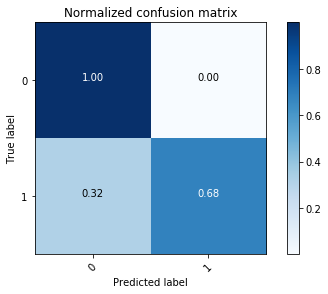

In [29]:
from sklearn.ensemble import AdaBoostClassifier

# CC
ada_cc = AdaBoostClassifier(random_state=100)
ada_cc.fit(x_cc_train, y_cc_train)
y_cc_preds = ada_cc.predict(x_cc_test)

roc_auc = metrics.roc_auc_score(y_cc_test, y_cc_preds)
precision = metrics.precision_score(y_cc_test, y_cc_preds)
recall = metrics.recall_score(y_cc_test, y_cc_preds)
accuracy = metrics.accuracy_score(y_cc_test, y_cc_preds)

print("ROC AUC: {}\nRecall: {}\nPrecision: {}\nAccuracy: {}".format(roc_auc, recall, precision, accuracy))
fpr, tpr, threshold = roc_curve(y_cc_test, y_cc_preds)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

cnf_matrix_cc = confusion_matrix(y_cc_test, y_cc_preds)
plt.figure()
plot_confusion_matrix(cnf_matrix_cc, classes=[0, 1], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

C:\Users\kinguyen\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


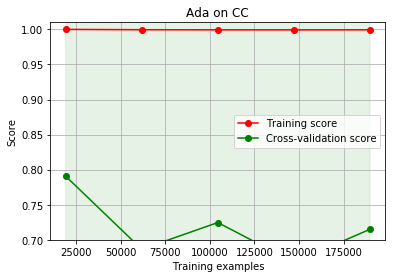

In [30]:
title = "Ada on CC"
plot_learning_curve(ada_cc, title, x_cc, y_cc, ylim=(0.7, 1.01), n_jobs=-1)
plt.show()

C:\Users\kinguyen\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]


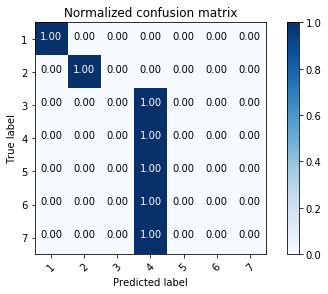

Accuracy: 0.7419354838709677


In [19]:
# zoo
ada_zoo = AdaBoostClassifier(random_state=100)
ada_zoo.fit(x_zoo_train, y_zoo_train)
y_zoo_preds = ada_zoo.predict(x_zoo_test)

cnf_matrix_zoo = confusion_matrix(y_zoo_test, y_zoo_preds)
plt.figure()
plot_confusion_matrix(cnf_matrix_zoo, classes=zoo_classes, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

accuracy = metrics.accuracy_score(y_zoo_test, y_zoo_preds)

print("Accuracy: {}".format(accuracy))

In [ ]:
title = "Ada on Zoo"
plot_learning_curve(ada_zoo, title, x_cc, y_cc, ylim=(0.7, 1.01), n_jobs=-1)
plt.show()

In [21]:
# CV
from sklearn.model_selection import cross_val_score

dtc = DecisionTreeClassifier(max_features='sqrt', min_samples_leaf=5)
scores_zoo = cross_val_score(dtc, x_zoo, y_zoo, cv=5, n_jobs=-1)
scores_cc = cross_val_score(dtc, x_cc, y_cc, cv=5, n_jobs=-1)
print("Decision Tree")
print("Zoo Accuracy: %0.2f (+/- %0.2f)" % (scores_zoo.mean(), scores_zoo.std() * 2))
print("CC Accuracy: %0.2f (+/- %0.2f)" % (scores_cc.mean(), scores_cc.std() * 2))

dtcb = DecisionTreeClassifier(max_features='sqrt', min_samples_leaf=10, class_weight='balanced')
scores_zoo = cross_val_score(dtcb, x_zoo, y_zoo, cv=5, n_jobs=-1)
scores_cc = cross_val_score(dtcb, x_cc, y_cc, cv=5, n_jobs=-1)
print("Decision Tree Balanced")
print("Zoo Accuracy: %0.2f (+/- %0.2f)" % (scores_zoo.mean(), scores_zoo.std() * 2))
print("CC Accuracy: %0.2f (+/- %0.2f)" % (scores_cc.mean(), scores_cc.std() * 2))

knn = KNeighborsClassifier()
scores_zoo = cross_val_score(knn, x_zoo, y_zoo, cv=5, n_jobs=-1)
scores_cc = cross_val_score(knn, x_cc, y_cc, cv=5, n_jobs=-1)
print("KNN")
print("Zoo Accuracy: %0.2f (+/- %0.2f)" % (scores_zoo.mean(), scores_zoo.std() * 2))
print("CC Accuracy: %0.2f (+/- %0.2f)" % (scores_cc.mean(), scores_cc.std() * 2))

mlp = MLPClassifier()
scores_zoo = cross_val_score(mlp, x_zoo, y_zoo, cv=5, n_jobs=-1)
scores_cc = cross_val_score(mlp, x_cc, y_cc, cv=5, n_jobs=-1)
print("Neural Network")
print("Zoo Accuracy: %0.2f (+/- %0.2f)" % (scores_zoo.mean(), scores_zoo.std() * 2))
print("CC Accuracy: %0.2f (+/- %0.2f)" % (scores_cc.mean(), scores_cc.std() * 2))

gb = GradientBoostingClassifier(min_samples_split=20)
scores_zoo = cross_val_score(gb, x_zoo, y_zoo, cv=5, n_jobs=-1)
scores_cc = cross_val_score(gb, x_cc, y_cc, cv=5, n_jobs=-1)
print("Gradient Boosting")
print("Zoo Accuracy: %0.2f (+/- %0.2f)" % (scores_zoo.mean(), scores_zoo.std() * 2))
print("CC Accuracy: %0.2f (+/- %0.2f)" % (scores_cc.mean(), scores_cc.std() * 2))

ada = AdaBoostClassifier()
scores_zoo = cross_val_score(ada, x_zoo, y_zoo, cv=5, n_jobs=-1)
scores_cc = cross_val_score(ada, x_cc, y_cc, cv=5, n_jobs=-1)
print("ADA Boosting")
print("Zoo Accuracy: %0.2f (+/- %0.2f)" % (scores_zoo.mean(), scores_zoo.std() * 2))
print("CC Accuracy: %0.2f (+/- %0.2f)" % (scores_cc.mean(), scores_cc.std() * 2))

svc_linear = SVC(kernel='linear')
scores_zoo = cross_val_score(svc_linear, x_zoo, y_zoo, cv=5, n_jobs=-1)
scores_cc = cross_val_score(svc_linear, x_cc, y_cc, cv=5, n_jobs=-1)
print("SVC Linear")
print("Zoo Accuracy: %0.2f (+/- %0.2f)" % (scores_zoo.mean(), scores_zoo.std() * 2))
print("CC Accuracy: %0.2f (+/- %0.2f)" % (scores_cc.mean(), scores_cc.std() * 2))

svc_rbf = SVC(kernel='rbf')
scores_zoo = cross_val_score(svc_linear, x_zoo, y_zoo, cv=5, n_jobs=-1)
scores_cc = cross_val_score(svc_linear, x_cc, y_cc, cv=5, n_jobs=-1)
print("SVC RBF")
print("Zoo Accuracy: %0.2f (+/- %0.2f)" % (scores_zoo.mean(), scores_zoo.std() * 2))
print("CC Accuracy: %0.2f (+/- %0.2f)" % (scores_cc.mean(), scores_cc.std() * 2))

C:\Users\kinguyen\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Decision Tree
Zoo Accuracy: 0.86 (+/- 0.14)
CC Accuracy: 0.80 (+/- 0.79)


C:\Users\kinguyen\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Decision Tree Balanced
Zoo Accuracy: 0.59 (+/- 0.28)
CC Accuracy: 0.81 (+/- 0.75)


C:\Users\kinguyen\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


KNN
Zoo Accuracy: 0.85 (+/- 0.09)
CC Accuracy: 0.45 (+/- 0.64)


C:\Users\kinguyen\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Neural Network
Zoo Accuracy: 0.96 (+/- 0.04)
CC Accuracy: 0.98 (+/- 0.07)


C:\Users\kinguyen\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Gradient Boosting
Zoo Accuracy: 0.95 (+/- 0.12)
CC Accuracy: 0.80 (+/- 0.79)


C:\Users\kinguyen\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


ADA Boosting
Zoo Accuracy: 0.73 (+/- 0.05)
CC Accuracy: 0.83 (+/- 0.68)


C:\Users\kinguyen\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


SVC Linear
Zoo Accuracy: 0.96 (+/- 0.07)
CC Accuracy: 0.98 (+/- 0.08)


C:\Users\kinguyen\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


SVC RBF
Zoo Accuracy: 0.96 (+/- 0.07)
CC Accuracy: 0.98 (+/- 0.08)


In [22]:
x_iris = x_zoo
y_iris = y_zoo

In [27]:
# CV
from sklearn.model_selection import cross_val_score

dtc = DecisionTreeClassifier(max_features='sqrt', min_samples_leaf=5)
scores_iris = cross_val_score(dtc, x_iris, y_iris, cv=5, scoring='f1', n_jobs=-1)
scores_cc = cross_val_score(dtc, x_cc, y_cc, cv=5, scoring='f1', n_jobs=-1)
print("Decision Tree")
print("Zoo F1: %0.2f (+/- %0.2f)" % (scores_iris.mean(), scores_iris.std() * 2))
print("CC F1: %0.2f (+/- %0.2f)" % (scores_cc.mean(), scores_cc.std() * 2))

dtcb = DecisionTreeClassifier(max_features='sqrt', min_samples_leaf=10, class_weight='balanced')
scores_iris = cross_val_score(dtcb, x_iris, y_iris, cv=5, scoring='f1', n_jobs=-1)
scores_cc = cross_val_score(dtcb, x_cc, y_cc, cv=5, scoring='f1', n_jobs=-1)
print("Decision Tree Balanced")
print("Zoo F1: %0.2f (+/- %0.2f)" % (scores_iris.mean(), scores_iris.std() * 2))
print("CC F1: %0.2f (+/- %0.2f)" % (scores_cc.mean(), scores_cc.std() * 2))

knn = KNeighborsClassifier()
scores_iris = cross_val_score(knn, x_iris, y_iris, cv=5, scoring='f1', n_jobs=-1)
scores_cc = cross_val_score(knn, x_cc, y_cc, cv=5, scoring='f1', n_jobs=-1)
print("KNN")
print("Zoo F1: %0.2f (+/- %0.2f)" % (scores_iris.mean(), scores_iris.std() * 2))
print("CC F1: %0.2f (+/- %0.2f)" % (scores_cc.mean(), scores_cc.std() * 2))

mlp = MLPClassifier()
scores_iris = cross_val_score(mlp, x_iris, y_iris, cv=5, scoring='f1', n_jobs=-1)
scores_cc = cross_val_score(mlp, x_cc, y_cc, cv=5, scoring='f1', n_jobs=-1)
print("Neural Network")
print("Zoo F1: %0.2f (+/- %0.2f)" % (scores_iris.mean(), scores_iris.std() * 2))
print("CC F1: %0.2f (+/- %0.2f)" % (scores_cc.mean(), scores_cc.std() * 2))

gb = GradientBoostingClassifier(min_samples_split=20)
scores_iris = cross_val_score(gb, x_iris, y_iris, cv=5, scoring='f1', n_jobs=-1)
scores_cc = cross_val_score(gb, x_cc, y_cc, cv=5, scoring='f1', n_jobs=-1)
print("Gradient Boosting")
print("Zoo F1: %0.2f (+/- %0.2f)" % (scores_iris.mean(), scores_iris.std() * 2))
print("CC F1: %0.2f (+/- %0.2f)" % (scores_cc.mean(), scores_cc.std() * 2))

ada = AdaBoostClassifier()
scores_iris = cross_val_score(ada, x_iris, y_iris, cv=5,scoring='f1', n_jobs=-1)
scores_cc = cross_val_score(ada, x_cc, y_cc, cv=5, scoring='f1', n_jobs=-1)
print("ADA Boosting")
print("Zoo F1: %0.2f (+/- %0.2f)" % (scores_iris.mean(), scores_iris.std() * 2))
print("CC F1: %0.2f (+/- %0.2f)" % (scores_cc.mean(), scores_cc.std() * 2))

svc_linear = SVC(kernel='linear')
scores_iris = cross_val_score(svc_linear, x_iris, y_iris, cv=5, scoring='f1', n_jobs=-1)
scores_cc = cross_val_score(svc_linear, x_cc, y_cc, cv=5, scoring='f1', n_jobs=-1)
print("SVC Linear")
print("Zoo F1: %0.2f (+/- %0.2f)" % (scores_iris.mean(), scores_iris.std() * 2))
print("CC F1: %0.2f (+/- %0.2f)" % (scores_cc.mean(), scores_cc.std() * 2))

svc_rbf = SVC(kernel='rbf')
scores_iris = cross_val_score(svc_linear, x_iris, y_iris, cv=5, scoring='f1', n_jobs=-1)
scores_cc = cross_val_score(svc_linear, x_cc, y_cc, cv=5, scoring='f1', n_jobs=-1)
print("SVC RBF")
print("Zoo F1: %0.2f (+/- %0.2f)" % (scores_iris.mean(), scores_iris.std() * 2))
print("CC F1: %0.2f (+/- %0.2f)" % (scores_cc.mean(), scores_cc.std() * 2))


C:\Users\kinguyen\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


ValueError: Target is multiclass but average='binary'. Please choose another average setting.

In [24]:
# CV
from sklearn.model_selection import cross_val_score

dtc = DecisionTreeClassifier(max_features='sqrt', min_samples_leaf=5)
scores_iris = cross_val_score(dtc, x_iris, y_iris, cv=5, n_jobs=-1)
scores_cc = cross_val_score(dtc, x_cc, y_cc, cv=5, scoring='f1_weighted', n_jobs=-1)
print("Decision Tree")
print("Iris Accuracy: %0.2f (+/- %0.2f)" % (scores_iris.mean(), scores_iris.std() * 2))
print("CC F1: %0.2f (+/- %0.2f)" % (scores_cc.mean(), scores_cc.std() * 2))

dtcb = DecisionTreeClassifier(max_features='sqrt', min_samples_leaf=5, class_weight='balanced')
scores_iris = cross_val_score(dtcb, x_iris, y_iris, cv=5, n_jobs=-1)
scores_cc = cross_val_score(dtcb, x_cc, y_cc, cv=5, scoring='f1_weighted', n_jobs=-1)
print("Decision Tree Balanced")
print("Iris Accuracy: %0.2f (+/- %0.2f)" % (scores_iris.mean(), scores_iris.std() * 2))
print("CC F1: %0.2f (+/- %0.2f)" % (scores_cc.mean(), scores_cc.std() * 2))

knn = KNeighborsClassifier()
scores_iris = cross_val_score(knn, x_iris, y_iris, cv=5, n_jobs=-1)
scores_cc = cross_val_score(knn, x_cc, y_cc, cv=5, scoring='f1_weighted', n_jobs=-1)
print("KNN")
print("Iris Accuracy: %0.2f (+/- %0.2f)" % (scores_iris.mean(), scores_iris.std() * 2))
print("CC F1: %0.2f (+/- %0.2f)" % (scores_cc.mean(), scores_cc.std() * 2))

mlp = MLPClassifier()
scores_iris = cross_val_score(mlp, x_iris, y_iris, cv=5, n_jobs=-1)
scores_cc = cross_val_score(mlp, x_cc, y_cc, cv=5, scoring='f1_weighted', n_jobs=-1)
print("Neural Network")
print("Iris Accuracy: %0.2f (+/- %0.2f)" % (scores_iris.mean(), scores_iris.std() * 2))
print("CC F1: %0.2f (+/- %0.2f)" % (scores_cc.mean(), scores_cc.std() * 2))

gb = GradientBoostingClassifier(min_samples_split=20)
scores_iris = cross_val_score(gb, x_iris, y_iris, cv=5, n_jobs=-1)
scores_cc = cross_val_score(gb, x_cc, y_cc, cv=5, scoring='f1_weighted', n_jobs=-1)
print("Gradient Boosting")
print("Iris Accuracy: %0.2f (+/- %0.2f)" % (scores_iris.mean(), scores_iris.std() * 2))
print("CC F1: %0.2f (+/- %0.2f)" % (scores_cc.mean(), scores_cc.std() * 2))

ada = AdaBoostClassifier()
scores_iris = cross_val_score(ada, x_iris, y_iris, cv=5, n_jobs=-1)
scores_cc = cross_val_score(ada, x_cc, y_cc, cv=5, scoring='f1_weighted', n_jobs=-1)
print("ADA Boosting")
print("Iris Accuracy: %0.2f (+/- %0.2f)" % (scores_iris.mean(), scores_iris.std() * 2))
print("CC F1: %0.2f (+/- %0.2f)" % (scores_cc.mean(), scores_cc.std() * 2))

svc_linear = SVC(kernel='linear')
scores_iris = cross_val_score(svc_linear, x_iris, y_iris, cv=5, n_jobs=-1)
scores_cc = cross_val_score(svc_linear, x_cc, y_cc, cv=5, scoring='f1_weighted', n_jobs=-1)
print("SVC Linear")
print("Iris Accuracy: %0.2f (+/- %0.2f)" % (scores_iris.mean(), scores_iris.std() * 2))
print("CC F1: %0.2f (+/- %0.2f)" % (scores_cc.mean(), scores_cc.std() * 2))

svc_rbf = SVC(kernel='rbf')
scores_iris = cross_val_score(svc_linear, x_iris, y_iris, cv=5, n_jobs=-1)
scores_cc = cross_val_score(svc_linear, x_cc, y_cc, cv=5, scoring='f1_weighted', n_jobs=-1)
print("SVC RBF")
print("Iris Accuracy: %0.2f (+/- %0.2f)" % (scores_iris.mean(), scores_iris.std() * 2))
print("CC F1: %0.2f (+/- %0.2f)" % (scores_cc.mean(), scores_cc.std() * 2))

# svc_linear = svm.SVC(kernel='linear')
# scores_iris = cross_val_score(svc_linear, x_iris, y_iris, cv=5)
# scores_cc = cross_val_score(svc_linear, x_cc, y_cc, cv=5)
# print("SVC Linear")
# print("Iris Accuracy: %0.2f (+/- %0.2f)" % (scores_iris.mean(), scores_iris.std() * 2))
# print("CC Accuracy: %0.2f (+/- %0.2f)" % (scores_cc.mean(), scores_cc.std() * 2))

C:\Users\kinguyen\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Decision Tree
Iris Accuracy: 0.85 (+/- 0.07)
CC F1: 0.80 (+/- 0.79)


C:\Users\kinguyen\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Decision Tree Balanced
Iris Accuracy: 0.81 (+/- 0.22)
CC F1: 0.99 (+/- 0.04)


C:\Users\kinguyen\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


KNN
Iris Accuracy: 0.85 (+/- 0.09)
CC F1: 0.55 (+/- 0.62)


C:\Users\kinguyen\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Neural Network
Iris Accuracy: 0.97 (+/- 0.05)
CC F1: 1.00 (+/- 0.01)


C:\Users\kinguyen\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Gradient Boosting
Iris Accuracy: 0.95 (+/- 0.12)
CC F1: 0.80 (+/- 0.79)


C:\Users\kinguyen\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


ADA Boosting
Iris Accuracy: 0.73 (+/- 0.05)
CC F1: 0.85 (+/- 0.59)


C:\Users\kinguyen\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


SVC Linear
Iris Accuracy: 0.96 (+/- 0.07)
CC F1: 0.99 (+/- 0.04)


C:\Users\kinguyen\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


SVC RBF
Iris Accuracy: 0.96 (+/- 0.07)
CC F1: 0.99 (+/- 0.04)


In [ ]:
# CV with Recall

dtc = DecisionTreeClassifier(max_features='sqrt', min_samples_leaf=5)
scores_iris = cross_val_score(dtc, x_iris, y_iris, cv=5, n_jobs=-1)
scores_cc = cross_val_score(dtc, x_cc, y_cc, cv=5, scoring='recall', n_jobs=-1)
print("Decision Tree")
print("Zoo Recall: %0.2f (+/- %0.2f)" % (scores_iris.mean(), scores_iris.std() * 2))
print("CC Recall: %0.2f (+/- %0.2f)" % (scores_cc.mean(), scores_cc.std() * 2))

dtcb = DecisionTreeClassifier(max_features='sqrt', min_samples_leaf=5, class_weight='balanced')
scores_iris = cross_val_score(dtcb, x_iris, y_iris, cv=5, n_jobs=-1)
scores_cc = cross_val_score(dtcb, x_cc, y_cc, cv=5, scoring='recall', n_jobs=-1)
print("Decision Tree Balanced")
print("Zoo Recall: %0.2f (+/- %0.2f)" % (scores_iris.mean(), scores_iris.std() * 2))
print("CC Recall: %0.2f (+/- %0.2f)" % (scores_cc.mean(), scores_cc.std() * 2))

knn = KNeighborsClassifier()
scores_iris = cross_val_score(knn, x_iris, y_iris, cv=5, n_jobs=-1)
scores_cc = cross_val_score(knn, x_cc, y_cc, cv=5, scoring='recall', n_jobs=-1)
print("KNN")
print("Zoo Recall: %0.2f (+/- %0.2f)" % (scores_iris.mean(), scores_iris.std() * 2))
print("CC Recall: %0.2f (+/- %0.2f)" % (scores_cc.mean(), scores_cc.std() * 2))

mlp = MLPClassifier()
scores_iris = cross_val_score(mlp, x_iris, y_iris, cv=5, n_jobs=-1)
scores_cc = cross_val_score(mlp, x_cc, y_cc, cv=5, scoring='recall', n_jobs=-1)
print("Neural Network")
print("Zoo Recall: %0.2f (+/- %0.2f)" % (scores_iris.mean(), scores_iris.std() * 2))
print("CC Recall: %0.2f (+/- %0.2f)" % (scores_cc.mean(), scores_cc.std() * 2))

gb = GradientBoostingClassifier(min_samples_split=20)
scores_iris = cross_val_score(gb, x_iris, y_iris, cv=5, n_jobs=-1)
scores_cc = cross_val_score(gb, x_cc, y_cc, cv=5, scoring='recall', n_jobs=-1)
print("Gradient Boosting")
print("Zoo Recall: %0.2f (+/- %0.2f)" % (scores_iris.mean(), scores_iris.std() * 2))
print("CC Recall: %0.2f (+/- %0.2f)" % (scores_cc.mean(), scores_cc.std() * 2))

ada = AdaBoostClassifier()
scores_iris = cross_val_score(ada, x_iris, y_iris, cv=5,n_jobs=-1)
scores_cc = cross_val_score(ada, x_cc, y_cc, cv=5, scoring='recall', n_jobs=-1)
print("ADA Boosting")
print("Zoo Recall: %0.2f (+/- %0.2f)" % (scores_iris.mean(), scores_iris.std() * 2))
print("CC Recall: %0.2f (+/- %0.2f)" % (scores_cc.mean(), scores_cc.std() * 2))

svc_linear = SVC(kernel='linear')
scores_iris = cross_val_score(svc_linear, x_iris, y_iris, cv=5n_jobs=-1)
scores_cc = cross_val_score(svc_linear, x_cc, y_cc, cv=5, scoring='recall', n_jobs=-1)
print("SVC Linear")
print("Zoo Recall: %0.2f (+/- %0.2f)" % (scores_iris.mean(), scores_iris.std() * 2))
print("CC Recall: %0.2f (+/- %0.2f)" % (scores_cc.mean(), scores_cc.std() * 2))

svc_rbf = SVC(kernel='rbf')
scores_iris = cross_val_score(svc_linear, x_iris, y_iris, cv=5,n_jobs=-1)
scores_cc = cross_val_score(svc_linear, x_cc, y_cc, cv=5, scoring='recall', n_jobs=-1)
print("SVC RBF")
print("Zoo Recall: %0.2f (+/- %0.2f)" % (scores_iris.mean(), scores_iris.std() * 2))
print("CC Recall: %0.2f (+/- %0.2f)" % (scores_cc.mean(), scores_cc.std() * 2))


C:\Users\kinguyen\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


SVC Linear
Iris Accuracy: 0.96 (+/- 0.07)
CC F1: 0.34 (+/- 0.65)


C:\Users\kinguyen\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


SVC RBF
Iris Accuracy: 0.96 (+/- 0.07)
CC F1: 0.34 (+/- 0.65)
